# Gender Analysis

Note: In this work we’ve limited our analyses to a grouping based on perceived binary gender because these labels already exist in the datasets we look at, even though it is not at all inclusive of all gender categories. We use the terms male and female to refer to binarized socially-perceived gender expression, and not gender identity nor sex assigned at birth, neither of which can be inferred from an image.

## Instructions
1. Fill in the dataset in section 1.1

2. Run all cells

3. Review the summary pdf generated AND/OR explore each metric below.
    - All metrics are identified by a short keyword, and consist of a "Setup" and "Analyses" portion. The "Setup" portion contains code that does not need to be modified unless customization is needed, and the "Analyses" portion provides an interactive display of the results.

## Table of Contents
1. [Initial Setup](#setup) <br/>
    1.1 [Dataset](#dataset)
2. att_siz Metric: [Distance from center, size, gender label inference](#att_siz)<br/>
    2.1 [Setup](#att_siz_setup)<br/>
    2.2 [Analyses](#att_siz_analyses)
3. att_cnt Metric: [Object occurrences and cooccurrences](#att_cnt)<br/>
    3.1 [Setup](#att_cnt_setup)<br/>
    3.2 [Analyses](#att_cnt_analyses)
4. att_dis Metric: [Distance from object as proxy for interaction](#att_dis)<br/>
    4.1 [Setup](#att_dis_setup)<br/>
    4.2 [Analyses](#att_dis_analyses)
5. att_clu Metric: [Linearly separable objects by gender](#att_clu)<br/>
    5.1 [Setup](#att_clu_setup)<br/>
    5.2 [Analyses](#att_clu_analyses)
6. att_scn Metric [Scenes](#att_scn)<br/>
    6.1 [Setup](#att_scn_setup)<br/>
    6.2 [Analyses](#att_scn_analyses)
7. [Setting up summary pdf](#summarypdf)

# Initial Setup
<a id="setup"></a>

In [20]:
from __future__ import print_function
import argparse
import datasets
import pickle
import itertools
import torchvision.transforms as transforms
import torch.utils.data as data
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
from scipy import stats
import PIL.Image
from scipy.cluster.hierarchy import dendrogram, linkage
from math import sqrt
import cv2
import matplotlib.patches as patches
from scipy.spatial.distance import squareform
import pycountry
from geonamescache import GeonamesCache
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import permutation_test_score
import re
import plotly.graph_objects as go
import textwrap
import matplotlib.patches as mpatches
import operator
from matplotlib.font_manager import FontProperties
import imageio
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, Layout
import ipywidgets as widgets
from IPython.display import Image
from IPython.core.display import HTML
from IPython.display import display
import time
import warnings
import random
from matplotlib.transforms import Bbox
from IPython.display import clear_output

In [21]:
COLORS = sns.color_palette('Set2', 2)
SAME_EXTENT = (-0.5, 6.5, -0.5, 6.5)
np.seterr(divide='ignore', invalid='ignore')
warnings.filterwarnings("ignore")

if not os.path.exists("dataloader_files"):
    os.mkdir("dataloader_files")
if not os.path.exists("results"):
    os.mkdir("results")
if not os.path.exists("checkpoints"):
    os.mkdir("checkpoints")

In [22]:
%matplotlib inline

In [23]:
# https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
def hide_toggle(for_next=False, toggle_text='Toggle show/hide'):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [24]:
hide_toggle(for_next=True, toggle_text='Show/hide helper functions')

In [25]:
def folder(num, folder):
    if not os.path.exists("results/{0}/{1}".format(folder, num)):
        os.mkdir("results/{0}/{1}".format(folder, num))
    file = open("results/{0}/{1}/results.txt".format(folder, num), "w")
    return file

# Projecting a set of features into a lower-dimensional subspace with PCA
def project(features, dim):
    standardized = StandardScaler().fit_transform(features)
    pca = PCA(n_components=dim)
    principalComponents = pca.fit_transform(X=standardized)
    return principalComponents

# Calculating the binomial proportion confidence interval
def wilson(p, n, z = 1.96):
    denominator = 1 + z**2/n
    centre_adjusted_probability = p + z*z / (2*n)
    adjusted_standard_deviation = sqrt((p*(1 - p) + z*z / (4*n)) / n)
    
    lower_bound = (centre_adjusted_probability - z*adjusted_standard_deviation) / denominator
    upper_bound = (centre_adjusted_probability + z*adjusted_standard_deviation) / denominator
    return (lower_bound, upper_bound)

def country_to_iso3(country):
    missing = {'South+Korea': 'KOR',
            'North+Korea': 'PRK',
            'Laos': 'LAO',
            'Caribbean+Netherlands': 'BES',
            'St.+Lucia': 'LCA',
            'East+Timor': 'TLS',
            'Democratic+Republic+of+Congo': 'COD',
            'Swaziland': 'SWZ',
            'Cape+Verde': 'CPV',
            'C%C3%B4te+d%C2%B4Ivoire': 'CIV',
            'Ivory+Coast': 'CIV',
            'Channel+Islands': 'GBR'
            }
    try:
        iso3 = pycountry.countries.search_fuzzy(country.replace('+', ' '))[0].alpha_3
    except LookupError:
        try:
            iso3 = missing[country]
        except KeyError:
            iso3 = None
    return iso3

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

def display_filepaths(filepaths, width=100, height=100):
    try: 
        sidebyside = widgets.HBox([widgets.Image(value=open(filepath, 'rb').read(), format='png', width=width, height=height) for filepath in filepaths], layout=Layout(height='{}px'.format(height)))
        display(sidebyside)
    except FileNotFoundError: 
        print('Some functionality not available for CocoDatasetNoImages Class')

def dec_to_show(p):
    if p < .001:
        return '{:0.3e}'.format(p)
    else:
        return round(p, 3)

## Dataset
Fill in below with dataset and file path names
<a id="dataset"></a>

In [26]:
transform_train = transforms.Compose([ 
        transforms.ToTensor()
        ])
dataset = datasets.CoCoDatasetNoImages(transform_train)
folder_name = 'coco_example'

# dataset = datasets.OpenImagesDataset(transform_train)
# folder_name = 'openimages_supp'

loading annotations into memory...
Done (t=11.41s)
creating index...
index created!


In [27]:
save_loc = '1_pager_gen'
os.system("rm -r results/{0}/{1}".format(folder_name, save_loc))
file = folder(save_loc, folder_name)
first_pass = True
to_write = {}
if not os.path.exists("checkpoints/{}".format(folder_name)):
    os.mkdir("checkpoints/{}".format(folder_name))

In [28]:
data_folder = None

distances = pickle.load(open("results/{}/att_dis.pkl".format(folder_name), "rb"))
sample_file = distances[0][0][0][3]
if not os.path.exists(sample_file):
    assert data_folder is not None, "initialize data_folder with folder path of your data"
    dataset.init_folder_path(data_folder)
    print("overwriting from_path() function")
    dataset.from_path = dataset.from_path_prerun
    

False /n/fs/visualai-scr/Data/Coco/2014data/train2014/COCO_train2014_000000348785.jpg


AssertionError: initialize data_folder with folder path of your data

# att_siz Metric: Distance from center, size, gender label inference
<a id="att_siz"></a>

## Setup
<a id="att_siz_setup"></a>

In [29]:
hide_toggle(for_next=True, toggle_text='Show/hide att_siz code')

In [31]:
info = pickle.load(open("results/{}/att_siz.pkl".format(folder_name), "rb"))
sizes = info['sizes']
dists = info['distances']
tiny_sizes = info['tiny_sizes']
no_faces = info['noface_sizes']
f_scenes = np.array(list(itertools.chain.from_iterable([chunk[2] for chunk in no_faces[0]])) + list(itertools.chain.from_iterable([chunk[1] for chunk in tiny_sizes[0]])))
m_scenes = np.array(list(itertools.chain.from_iterable([chunk[2] for chunk in no_faces[1]])) + list(itertools.chain.from_iterable([chunk[1] for chunk in tiny_sizes[1]])))
tiny_sizes[0] = [chunk[0] for chunk in tiny_sizes[0]]
tiny_sizes[1] = [chunk[0] for chunk in tiny_sizes[1]]
no_faces[0] = [chunk[0] for chunk in no_faces[0]]
no_faces[1] = [chunk[0] for chunk in no_faces[1]]

info = pickle.load(open('util_files/places_scene_info.pkl', 'rb'))
idx_to_scene = info['idx_to_scene']
idx_to_scenegroup = info['idx_to_scenegroup']
sceneidx_to_scenegroupidx = info['sceneidx_to_scenegroupidx']

xaxis = [idx_to_scenegroup[i] for i in range(len(idx_to_scenegroup))]
xaxis = ['\n'.join(textwrap.wrap(chunk, width=30)) for chunk in xaxis]
barWidth = .4
fontsize = 15

r1 = np.arange(len(idx_to_scenegroup))
scenes_f = np.bincount(f_scenes)
scenes_m = np.bincount(m_scenes)

total_images = np.sum(scenes_f+scenes_m)
scenes_f, scenes_m = scenes_f / total_images, scenes_m / total_images
all_sizes = [tiny_sizes[0]+no_faces[0]+sizes[0], tiny_sizes[1]+no_faces[1]+sizes[1]]

def numbers_where_gender_inferred():

    tiny_females, tiny_males = len(tiny_sizes[0]), len(tiny_sizes[1])
    noface_females, noface_males = len(no_faces[0]), len(no_faces[1])
    original_females, original_males = tiny_females+noface_females+len(sizes[0]), tiny_males+noface_males+len(sizes[1])
    print("Total images: {0}, and {1} were male, {2} were female. {3}x".format(original_females+original_males, original_males, original_females, round(original_males/original_females, 4)))
    try:
        print("Discarded {0} images for being too small, and {1} were male, {2} were female. {3}x".format(tiny_females+tiny_males, tiny_males, tiny_females, round(tiny_males/tiny_females, 4)))
    except ZeroDivisionError:
        print("Discarded {0} images for being too small, and {1} were male, {2} were female.".format(tiny_females+tiny_males, tiny_males, tiny_females))
    try:
        print("Discarded {0} images for having no face detected, and {1} were male, {2} were female. {3}x".format(noface_females+noface_males,noface_males, noface_females, round(noface_males/noface_females, 4)))
    except ZeroDivisionError:
        print("Discarded {0} images for having no face detected, and {1} were male, {2} were female.".format(noface_females+noface_males,noface_males, noface_females))
    print("There were {0} male images and {1} female images included. {2}x".format(len(sizes[1]), len(sizes[0]), round(len(sizes[1])/len(sizes[0]), 4)))

    # P(male|no face)
    nogender_males = tiny_males + noface_males
    nogender_females = tiny_females + noface_females
    prob = nogender_males / (nogender_males + nogender_females)
    prob_statement = "Probability image is labeled male when it should not be, i.e. given there's no face detected or person is too small: {}".format(round(prob, 4))
    if (prob < .45 or prob > .55) and first_pass:
        to_write[0] = ["(att_siz) " + prob_statement]
    print()
    print(prob_statement)


def scenes_where_no_face():
    fig = plt.figure(figsize=(12, 6))
    r2 = [x + barWidth for x in r1]
    
    scene_mf_ratios = np.divide(scenes_m, scenes_f)
    order = np.argsort(scene_mf_ratios)
    
    biggest_diff_scenes = []
    if first_pass and scene_mf_ratios[order[-1]] > 1.:
        biggest_diff_scenes.append("{0} is the scene where the label of male is most likely to be picked over that of female".format(xaxis[order[-1]]))
    if first_pass and scene_mf_ratios[order[0]] < 1.:
        biggest_diff_scenes.append("{0} is the scene where the label of female is most likely to be picked over that of male".format(xaxis[order[0]]))
    if len(biggest_diff_scenes) > 0:
        to_write[1] = biggest_diff_scenes
    
    plt.barh(r2, scenes_m[order], height=barWidth, color=COLORS[1], edgecolor='white', label='male')
    plt.barh(r1, scenes_f[order], height=barWidth, color=COLORS[0], edgecolor='white', label='female')
    plt.yticks([r + (barWidth/2.) for r in range(len(r1))], np.array(xaxis)[order], fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylabel('Scene', fontsize=fontsize)
    plt.xlabel('Proportion of Images Discarded with this Scene', fontsize=fontsize)
    plt.legend(loc='best', prop={'size': fontsize})
    plt.title("Scenes where gender was labeled when it should not have been", fontsize=fontsize)
    plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.18)
    plt.gcf().subplots_adjust(left=0.4)
    plt.show()
    
comparisons_widget = widgets.Dropdown(options=['Sizes', 'Distances', 'All sizes', 'Sizes where no face was detected'], value='Sizes')
prob_v_freq_toggle = widgets.ToggleButton(value=True, description="Probability View", layout=Layout(width='200px'))

def compare_sizedist(metric, view):
    def mean_and_std(data, data_type):
        f = data[0]
        m = data[1]

        histf, binsf = np.histogram(f, bins='auto')
        histm, binsm = np.histogram(m, bins='auto')

        if binsm[-1] > binsf[-1]:
            bins = binsm
        else:
            bins = binsf
        try:
            biggest = max(max(f), max(m))
        except ValueError:
            biggest = 1.
        prob_bins = np.arange(0, biggest, biggest / 15)
        histf, _ = np.histogram(f, bins=prob_bins)
        histm, _ = np.histogram(m, bins=prob_bins)
        histf = histf/len(f)
        histm = histm/len(m)
        conditioned = np.divide(histf, histf+histm)
        
        f_mean = np.mean(f)
        m_mean = np.mean(m)
        f_std = np.std(f)
        m_std = np.std(m)
        t, p = stats.ttest_ind(f, m)
        
        to_save = False
        if view is None and p < .05 and first_pass:
            data_descrip = ''
            if data_type == 'dists':
                data_descrip = 'Distance from center'
            if data_type == 'sizes':
                data_descrip = 'Fraction of image taken up by a person'
            to_write[2] = ["(att_siz) {0} is different between the genders with a p-value of {1}, distribution shown below".format(data_descrip, dec_to_show(p))]
            to_save = True
        
        if view is None or view:

            prob_v_freq_toggle.description = 'Probability view'
            histogram_f, bins_f = np.histogram(f, bins='auto')
            bin_centers_f = 0.5*(bins_f[1:] + bins_f[:-1])
            area_f = np.trapz(histogram_f, x=bin_centers_f)
            plt.plot(bin_centers_f, histogram_f/area_f, alpha=.75, label='female', color=COLORS[0])

            histogram_m, bins_m = np.histogram(m, bins='auto')
            bin_centers_m = 0.5*(bins_m[1:] + bins_m[:-1])
            area_m = np.trapz(histogram_m, x=bin_centers_m)
            plt.plot(bin_centers_m, histogram_m/area_m, alpha=.75, label='male', color=COLORS[1])
            plt.legend(loc='upper right')
            plt.xlabel('Distances' if data_type == 'dists' else 'Sizes')
            plt.ylabel('Frequency')
            if to_save and first_pass:
                plt.savefig("results/{0}/{1}/0.png".format(folder_name, save_loc))
                plt.close()
            elif view is None:
                plt.close()
            else:
                plt.show()
        else:
            prob_v_freq_toggle.description = 'Frequency view'
            plt.scatter(np.arange(len(conditioned)), conditioned)
            plt.plot(np.arange(len(conditioned)), [.5] * len(conditioned), color='red')
            plt.xticks(np.arange(len(conditioned)), ['{0} to {1}'.format(round(prob_bins[i], 2), round(prob_bins[i+1], 2)) for i in range(len(conditioned))], rotation='vertical', fontsize='6')
            plt.xlabel('Distances' if data_type == 'dists' else 'Sizes')
            plt.ylabel('Probability of Female')
            plt.tight_layout()
            plt.show()

        if view is not None:
            print("Female: {0} +- {1}\n".format(round(f_mean, 4), round(f_std, 4)))
            print("Male: {0} +- {1}\n".format(round(m_mean, 4), round(m_std, 4)))
            print("P value that they are different: {}\n".format('{:0.3e}'.format(p)))
        

    if metric == 'Sizes':
        mean_and_std(sizes, 'sizes')
    elif metric == 'All sizes':
        mean_and_std(all_sizes, 'all_sizes')
    elif metric == 'Sizes where no face was detected':
        mean_and_std(no_faces, 'no_faces')  
    elif metric == 'Distances':
        mean_and_std(dists, 'dists')
    elif metric == 'first_pass' and first_pass:
        mean_and_std(sizes, 'sizes')
        mean_and_std(dists, 'dists')


## Analyses
<a id="att_siz_analyses"></a>

Statistics on how many gender labels were inferred when they shouldn't have been because the person was either too small, or no face was detected. The scenes where this happens are shown to investigate if perhaps annotators are relying on contextual clues to make this assumption.

Total images: 22761, and 16168 were male, 6593 were female. 2.4523x
Discarded 12 images for being too small, and 12 were male, 0 were female.
Discarded 4165 images for having no face detected, and 3204 were male, 961 were female. 3.334x
There were 12952 male images and 5632 female images included. 2.2997x

Probability image is labeled male when it should not be, i.e. given there's no face detected or person is too small: 0.7699


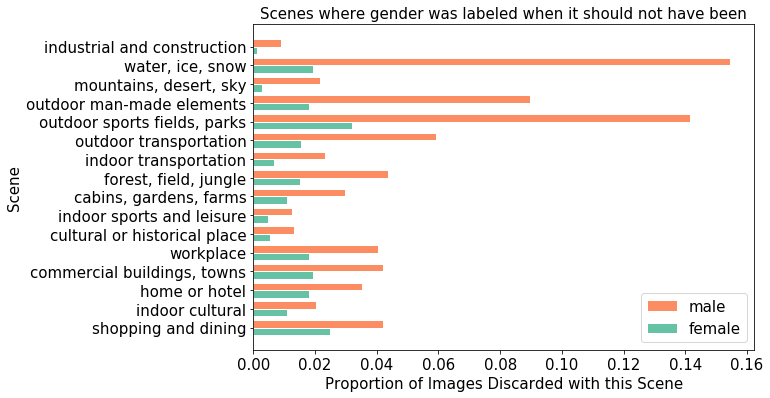

In [32]:
numbers_where_gender_inferred()
scenes_where_no_face()

Distribution by gender of sizes and distances, both after removing images where gender was unlikely to be able to be labeled, all sizes before any images were removed, and the sizes of people where no face was detected. 

In [33]:
if first_pass:
    compare_sizedist('first_pass', None)
all_things = [comparisons_widget, prob_v_freq_toggle]
ui = HBox(all_things)
out = widgets.interactive_output(compare_sizedist, {'metric': comparisons_widget, 'view': prob_v_freq_toggle})
display(ui, out)

Output()

# att_cnt Metric: Object occurrences and cooccurrences
<a id="att_cnt"></a>

## Setup
<a id="att_cnt_setup"></a>

In [34]:
hide_toggle(for_next=True, toggle_text='Show/hide att_cnt code')

In [35]:
categories = dataset.categories
names = dataset.labels_to_names
counts = pickle.load(open("results/{}/att_cnt.pkl".format(folder_name), "rb"))

topn = 10
counts_mat_f = np.zeros((len(categories), len(categories)))
counts_mat_m = np.zeros((len(categories), len(categories)))

# Create the cooccurrence matrix from the counts
counts_f = counts[0]
counts_m = counts[1]
for key in counts_f.keys():
    a, b = key.split('-')
    a, b = int(a), int(b)
    counts_mat_f[b][a] = counts_f[key]
    counts_mat_f[a][b] = counts_f[key]
    counts_mat_m[b][a] = counts_m[key]
    counts_mat_m[a][b] = counts_m[key]
instance_counts_f = np.diagonal(counts_mat_f)
instance_counts_m = np.diagonal(counts_mat_m)
normalized_f = np.divide(counts_mat_f, instance_counts_f)
normalized_m = np.divide(counts_mat_m, instance_counts_m)

def make_dist(counts, total):
    samples = np.zeros(total)
    samples[:int(counts)] = 1
    return samples

# Looking at if the number of times an object appears with different genders is statistically significant
p_values = [stats.ttest_ind(make_dist(instance_counts_f[i], dataset.num_gender_images[0]), make_dist(instance_counts_m[i], dataset.num_gender_images[1]))[1] for i in range(len(instance_counts_f))]
norm_instance_counts_f = instance_counts_f / dataset.num_gender_images[0]
norm_instance_counts_m = instance_counts_m / dataset.num_gender_images[1]

xaxis = [names[i] for i in categories]
barWidth = .4

# Graphs the counts of each supercategory by gender
def supercategory_by_gender():
    if dataset.group_mapping is not None:
        fontsize = 15
        supercategory_counts_f = np.zeros(len(dataset.supercategories_to_names))
        supercategory_counts_m = np.zeros(len(dataset.supercategories_to_names))
        for i in range(len(categories)):
            supercat = dataset.group_mapping(categories[i])
            supercategory_counts_f[supercat] += norm_instance_counts_f[i]
            supercategory_counts_m[supercat] += norm_instance_counts_m[i]
        supercategory_counts_f = supercategory_counts_f[1:]
        supercategory_counts_m = supercategory_counts_m[1:]

        supercategory_counts_f, supercategory_counts_m = np.array(supercategory_counts_f), np.array(supercategory_counts_m)

        fig = plt.figure(figsize=(10, 6))
        r1 = np.arange(len(dataset.supercategories_to_names)-1)
        r2 = [x + barWidth for x in r1]
        order = np.argsort(np.divide(supercategory_counts_m, supercategory_counts_f))
        plt.barh(r2, supercategory_counts_m[order], height=barWidth, color=COLORS[1], edgecolor='white', label='male')
        plt.barh(r1, supercategory_counts_f[order], height=barWidth, color=COLORS[0], edgecolor='white', label='female')
        plt.yticks([r + (barWidth/2.) for r in range(len(r1))], np.array([dataset.supercategories_to_names[i+1] for i in range(len(r1))])[order], fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.legend(loc='best', fontsize=fontsize)
        plt.ylabel('Object Category', fontsize=fontsize, labelpad=20)
        plt.xlabel('Fraction of Images that contain this Category', fontsize=fontsize, labelpad=20, x=.3)
        plt.tight_layout()
        plt.gcf().subplots_adjust(bottom=0.18)
        plt.gcf().subplots_adjust(left=0.28)
        if first_pass:
            to_write[3] = ['(att_cnt) Distribution of object categories each gender appears with, sorted by ratio between the two.']
            plt.savefig("results/{0}/{1}/1.png".format(folder_name, save_loc))
        plt.show()

# Graphs the ratio of instance counts if they are statistically significant
indices_to_keep = [i for i in range(len(instance_counts_f)) if categories[i] not in dataset.people_labels]
instance_sig_f = norm_instance_counts_f[indices_to_keep]
instance_sig_m = norm_instance_counts_m[indices_to_keep]
xaxis_sig = np.array(xaxis)[indices_to_keep]
pvalues_sig = np.array(p_values)[indices_to_keep]
all_ratios = []

for i in range(len(instance_sig_f)):
    f_count = instance_sig_f[i]
    m_count = instance_sig_m[i]
    if f_count > m_count:
        all_ratios.append(f_count / m_count)
    else:
        all_ratios.append(-m_count / f_count)

    if np.absolute(all_ratios[-1]) <= 1:
        all_ratios[-1] = 0

all_ratios = np.array(all_ratios)

def show_instance_ratios(sort_by, topn):
    infinities = np.concatenate([np.where(all_ratios == -np.inf)[0], np.where(all_ratios == np.inf)[0]], axis=None)
    
    all_ratios[all_ratios == -np.inf] = 0
    all_ratios[all_ratios == np.inf] = 0
    
    to_save = False
    if topn is None:
        topn = 5
        to_save = True
    
    if sort_by == 'pvalue':
        top_indices = np.argsort(pvalues_sig)[:topn][::-1]
        if to_save:
            for i in reversed(range(topn)):
                if pvalues_sig[top_indices[i]] >= .05:
                    top_indices.pop()
            topn = len(top_indices)
            if len(top_indices) == 0:
                return
                to_save = False
    elif sort_by == 'ratio':
        top_indices = np.argsort(np.absolute(all_ratios))[-topn:]
    instance_sig_f_topn = instance_sig_f[top_indices]
    instance_sig_m_topn = instance_sig_m[top_indices]
    xaxis_sig_topn = xaxis_sig[top_indices]
    all_ratios_topn = all_ratios[top_indices]

    fig = plt.figure(figsize=(10, max(2, topn // 3)))
    fontsize = 10
    less_indices = np.where(np.array(all_ratios_topn) < 0)[0]
    pltbar = plt.barh(np.arange(topn), np.absolute(all_ratios_topn))
    for ind in less_indices:
        pltbar[ind].set_color('C1')
    plt.yticks(np.arange(topn), xaxis_sig_topn[:topn], rotation='horizontal', fontsize=fontsize)
    ax = plt.gca()
    ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
    ax.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)
    plt.ylabel('Categories', fontsize=fontsize)
    plt.xlabel('Counts Ratio', fontsize=fontsize)
    patch1 = mpatches.Patch(color='C0', label='female')
    patch2 = mpatches.Patch(color='C1', label='male')
    handles = [patch1, patch2]
    fontP = FontProperties()
    fontP.set_size(12)
    lgd = plt.legend(handles=handles, prop=fontP, loc='best')
    plt.tight_layout()
    if to_save:
        to_write[4] = ['(att_cnt) Objects that are most statistically significantly represented with one gender over the other.']
        plt.savefig("results/{0}/{1}/2.png".format(folder_name, save_loc))
        plt.close()
        return
    else:
        plt.show()

    if len(infinities) > 0:
        print("Categories where one gender had 0 occurrences with that object:\n")
        
    # Categories where one gender had 0 occurrences with that object
    for index in infinities:
        print("{0}: F={1}, M={2}\n".format(xaxis_sig_topn[index], int(instance_sig_f_topn[index]*dataset.num_gender_images[0]), int(instance_sig_m_topn[index]*dataset.num_gender_images[1])))

    print("Numbers for graph:\n")

    for index in reversed(range(topn)):
        print("{0}: F={1}, M={2}, rat: {3}".format(xaxis_sig_topn[index], int(instance_sig_f_topn[index]*dataset.num_gender_images[0]), int(instance_sig_m_topn[index]*dataset.num_gender_images[1]), round(np.absolute(all_ratios_topn[index]), 4)))

p_values = np.zeros_like(counts_mat_f)
f_mi = np.zeros_like(counts_mat_f)
m_mi = np.zeros_like(counts_mat_f)
f_mi_wilson = np.zeros_like(counts_mat_f)
m_mi_wilson = np.zeros_like(counts_mat_f)
for i in range(len(categories)):
    for j in range(len(categories)):
        if categories[i] in dataset.people_labels or categories[j] in dataset.people_labels:
            p_values[i][j] = -1
        else:
            len_f = instance_counts_f[j] + instance_counts_f[i] - counts_mat_f[i][j]
            f = np.zeros(int(len_f))
            f[:int(counts_mat_f[i][j])] = 1
            len_m = instance_counts_m[j] + instance_counts_m[i] - counts_mat_m[i][j]
            m = np.zeros(int(len_m))
            m[:int(counts_mat_m[i][j])] = 1
            f_mi[i][j] = np.mean(f)
            m_mi[i][j] = np.mean(m)
            f_mi_wilson[i][j] = wilson(np.mean(f), len_f)[0]
            m_mi_wilson[i][j] = wilson(np.mean(m), len_m)[0]
            p_values[i][j] = stats.ttest_ind(f, m)[1]

flat_p = p_values.flatten()
flat_p[flat_p!=flat_p] = float("inf")
flat_p[flat_p == -1] = float("inf")
normalized_indices = np.argsort(flat_p)

def cooccurrence_counts_mi(topn):
    print("Statistically significant mutual information:\n")
    i, j = 0, 0
    while j < topn:
        index = normalized_indices[i]
        a, b = index % len(categories), index // len(categories)
        if a < b:
            print("{0} - {1}: {2}".format(names[categories[a]], names[categories[b]], '{:0.3e}'.format(flat_p[index])))
            print("F: {0}, M: {1}".format(round(f_mi.flatten()[index], 4), round(m_mi.flatten()[index], 4)))
            print()
            j += 1
        i += 1

## Analyses
<a id="att_cnt_analyses"></a>

Distribution of object categories by gender

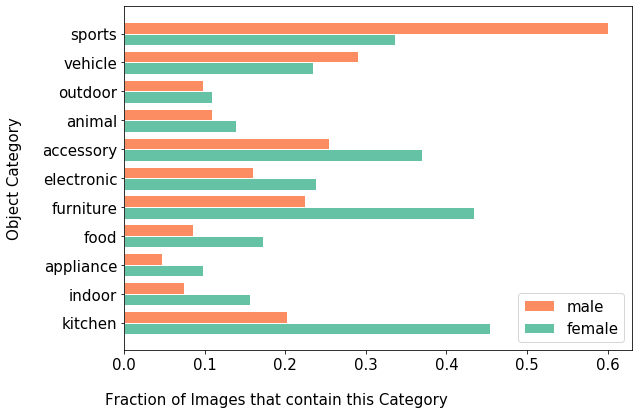

In [36]:
if dataset.group_mapping is not None:
    supercategory_by_gender()

Ratio between how often an object is represented with each gender (normalized), sorted by p-value or ratio.

In [37]:
instanceratio_slider = widgets.IntSlider(min=5, max=50, step=1, value=10)
instanceratio_sortby = widgets.Dropdown(options=['pvalue', 'ratio'], value='pvalue')

if first_pass:
    show_instance_ratios('pvalue', None)

all_things = [instanceratio_sortby, instanceratio_slider]
ui = HBox(all_things)
out = widgets.interactive_output(show_instance_ratios, {'sort_by': instanceratio_sortby, 'topn': instanceratio_slider})
display(ui, out)

Output()

Most statistically significant object cooccurrences, measured by mutual information, between the genders. The p-value is shown for the difference of the distributions, and the numbers for "F" and "M" indicate the mutual information for each gender on the object pair.

In [38]:
interact(cooccurrence_counts_mi, topn=widgets.IntSlider(min=1, max=30, step=1, value=10));

interactive(children=(IntSlider(value=10, description='topn', max=30, min=1), Output()), _dom_classes=('widget…

# att_dis Metric : Distance from object as proxy for interaction
<a id="att_dis"></a>

## Setup
<a id="att_dis_setup"></a>

In [ ]:
hide_toggle(for_next=True, toggle_text='Show/hide att_dis code')

In [39]:
categories = dataset.categories
names = dataset.labels_to_names
distances = pickle.load(open("results/{}/att_dis.pkl".format(folder_name), "rb"))
topn = 10

f_all_dists = []
m_all_dists = []
f_distr_dists = []
m_distr_dists = []
p_values = []
file_paths_f = []
file_paths_m = []
indices_f = []
indices_m = []
# Calculates the distances from person to each instance, and if it's a statistically significant difference
for i in range(len(categories)):
    f_dist = np.array([ (chunk[0] / np.sqrt(chunk[1]*chunk[2])) for chunk in distances[i][0] if chunk[2] != 0 and chunk[1] != 0])
    m_dist = np.array([ (chunk[0] / np.sqrt(chunk[1]*chunk[2])) for chunk in distances[i][1] if chunk[2] != 0 and chunk[1] != 0])
    f_file = np.array([ chunk[3] for chunk in distances[i][0] if chunk[2] != 0 and chunk[1] != 0])
    m_file = np.array([ chunk[3] for chunk in distances[i][1] if chunk[2] != 0 and chunk[1] != 0])
    f_index = np.array([ chunk[4] for chunk in distances[i][0] if chunk[2] != 0 and chunk[1] != 0])
    m_index = np.array([ chunk[4] for chunk in distances[i][1] if chunk[2] != 0 and chunk[1] != 0])
    t, p = stats.ttest_ind(f_dist, m_dist)
    p_values.append(p)
    f_distr_dists.append(f_dist)
    m_distr_dists.append(m_dist)
    f_all_dists.append(np.mean(f_dist))
    m_all_dists.append(np.mean(m_dist))
    file_paths_f.append(f_file)
    file_paths_m.append(m_file)
    indices_f.append(f_index)
    indices_m.append(m_index)
f_all_dists, m_all_dists = np.array(f_all_dists), np.array(m_all_dists)

xaxis = [names[i] for i in categories]

# Only retaining inforamtion for distances that are statistically significantly different, and are not people
indices_to_keep = [i for i in range(len(f_all_dists)) if categories[i] not in dataset.people_labels]
f_sig_dists = f_all_dists[indices_to_keep]
m_sig_dists = m_all_dists[indices_to_keep]
f_distr_dists = np.array(f_distr_dists)[indices_to_keep]
m_distr_dists = np.array(m_distr_dists)[indices_to_keep]
file_paths_f = np.array(file_paths_f)[indices_to_keep]
file_paths_m = np.array(file_paths_m)[indices_to_keep]
indices_f = np.array(indices_f)[indices_to_keep] 
indices_m = np.array(indices_m)[indices_to_keep] 
xaxis_sig = np.array(xaxis)[indices_to_keep]
pvalues_sig = np.array(p_values)[indices_to_keep]

all_ratios = []
for i in range(len(f_sig_dists)):
    f_count = f_sig_dists[i]
    m_count = m_sig_dists[i]
    if f_count > m_count:
        all_ratios.append(f_count / m_count)
    else:
        all_ratios.append(m_count / -f_count)
    if np.absolute(all_ratios[-1]) <= 1:
        all_ratios[-1] = 0
all_ratios = np.array(all_ratios)

distance_ratio_options = [("{0}: p-value {1}, {2}x".format(xaxis_sig[i], '{:0.2e}'.format(pvalues_sig[i]), round(all_ratios[i], 3)), i) for i in np.argsort(pvalues_sig)]

def show_distance_ratios(sort_by, topn):

    if sort_by == 'pvalue':
        top_indices = np.argsort(pvalues_sig)[:topn][::-1]
    elif sort_by == 'ratio':
        top_indices = np.argsort(np.absolute(all_ratios))[-topn:]
        
    fontsize = 10
    fig = plt.figure(figsize=(8, max(2, topn // 3)))
    
    all_ratios_topn = all_ratios[top_indices]
    xaxis_sig_topn = xaxis_sig[top_indices]

    negatives = np.where(all_ratios_topn > 0)[0]
    pltbar = plt.barh(np.arange(topn), np.absolute(all_ratios_topn), tick_label=xaxis_sig_topn)
    for neg in negatives:
        pltbar[neg].set_color('C1')
    patch1 = mpatches.Patch(color='C0', label='female')
    patch2 = mpatches.Patch(color='C1', label='male')
    handles = [patch1, patch2]
    fontP = FontProperties()
    fontP.set_size(12)
    lgd = plt.legend(handles=handles, prop=fontP)
    plt.xlabel('Categories', fontsize=fontsize)
    plt.ylabel('Distance Ratio', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()        
    plt.show()

distanceratio_slider = widgets.IntSlider(min=5, max=50, step=1, value=10)
distanceratio_sortby = widgets.Dropdown(options=['pvalue', 'ratio'], value='pvalue')

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

    save_box_images(bpf, f, file_paths_f[i*20:(i+1)*20], indices_f[i*20:(i+1)*20], 
        bpm, m, file_paths_m[i*20:(i+1)*20], indices_m[i*20:(i+1)*20],
        xaxis_sig[i*20:(i+1)*20], boxfolder)

# Saves qualitative images for each of the quartiles of distance
def save_box_images(bpf, f_array, file_paths_f, indices_f, bpm, m_array, file_paths_m, indices_m, names, to_save=False):
    a = bpf['whiskers'][0].get_data()[1][1]
    b = bpf['whiskers'][0].get_data()[1][0]
    c = bpf['medians'][0].get_data()[1][0]
    d = bpf['whiskers'][1].get_data()[1][0]
    e = bpf['whiskers'][1].get_data()[1][1]
    box_nums_f = [a, b, c, d, e]
    a = bpm['whiskers'][0].get_data()[1][1]
    b = bpm['whiskers'][0].get_data()[1][0]
    c = bpm['medians'][0].get_data()[1][0]
    d = bpm['whiskers'][1].get_data()[1][0]
    e = bpm['whiskers'][1].get_data()[1][1]
    box_nums_m = [a, b, c, d, e]
    fig = plt.figure(figsize=(16, 8))
    for j in range(5):
        for k in range(2):
            if k == 0:
                index = find_nearest(f_array, box_nums_f[j])
                indices = indices_f
                file_paths = file_paths_f
                gender = 'f'
            else:
                index = find_nearest(m_array, box_nums_m[j])
                indices = indices_m
                file_paths = file_paths_m
                gender = 'm'
            file_path = file_paths[index]
            ann_index = indices[index]
            image, anns = dataset.from_path(file_path)
            image = image.data.cpu().numpy().transpose(1, 2, 0)
            ann = anns[0][ann_index]['bbox']
            ann_0 = (ann[0]*image.shape[1], ann[2]*image.shape[0])
            ann_w = (ann[1]-ann[0])*image.shape[1]
            ann_h = (ann[3]-ann[2])*image.shape[0]
            per = anns[1][1]
            per_0 = (per[0]*image.shape[1], per[2]*image.shape[0])
            per_w = (per[1]-per[0])*image.shape[1]
            per_h = (per[3]-per[2])*image.shape[0]

            if k == 0:
                ax = fig.add_subplot(2, 5, j+1)
            else:
                ax = fig.add_subplot(2, 5, j+6)
            rect = patches.Rectangle(ann_0,ann_w, ann_h, linewidth=2,edgecolor='b',facecolor='none')
            ax.add_patch(rect)
            rect = patches.Rectangle(per_0,per_w, per_h, linewidth=2,edgecolor='r',facecolor='none')
            ax.add_patch(rect)

            title = 'min'
            if j == 1:
                title = 'lower quartile'
            elif j == 2:
                title = 'median'
            elif j == 3:
                title = 'upper quartile'
            elif j == 4:
                title = 'max'
            ax.set_title(gender.upper() + ': ' + title, fontsize=22)
            ax.axis("off")
            im = ax.imshow(image, alpha=.66)

    if to_save:
        if np.mean(f_array) < np.mean(m_array):
            closer_sent = 'Females are closer than males.'
        else:
            closer_sent = 'Males are closer than females.'
        to_write[5] = ["(att_dis) Qualitative example of {0}, which has the biggest ratio in distance between object and person (which can be interpreted as a proxy for interaction) between the genders. ".format(names) + closer_sent + " There is a red box around the person, and blue box around the object."]
        plt.savefig("results/{0}/{1}/3.png".format(folder_name, save_loc))
        plt.close()
    else:
        plt.show()

def qualitative_boxexamples(cat_index):
    try: 
        to_save = False
        if cat_index is None and first_pass:
            to_save = True
            cat_index = distance_ratio_options[0][1]

        f = f_distr_dists[cat_index]
        m = m_distr_dists[cat_index]

        bpf = plt.boxplot(f, sym='', widths=0.6)
        bpm = plt.boxplot(m, sym='', widths=0.6)
        plt.close()

        save_box_images(bpf, f, file_paths_f[cat_index], indices_f[cat_index], 
            bpm, m, file_paths_m[cat_index], indices_m[cat_index],
            xaxis_sig[cat_index], to_save)
    except (AttributeError, FileNotFoundError): 
        print('Some functionality not available for CoCoDatasetNoImages Class')

## Analyses
<a id="att_dis_analyses"></a>

Ratio of distance between an object and person by gender, sorted by p-value or ratio.

In [40]:
all_things = [distanceratio_sortby, distanceratio_slider]
ui = HBox(all_things)
out = widgets.interactive_output(show_distance_ratios, {'sort_by': distanceratio_sortby, 'topn': distanceratio_slider})
display(ui, out)

Output()

Qualitative examples of person (red box) of each gender with the object (red box), representing the different quartiles of distance. The values in the dropdown menu represent the p-value for the independence of the female and male distance distributions, and the ratio is that of distance between male and female, where negative means it is closer for females, and positive means it is closer for males.

In [41]:
if first_pass:
    qualitative_boxexamples(None)
interact(qualitative_boxexamples, cat_index=widgets.Dropdown(options=distance_ratio_options, layout=Layout(width='400px')));

Some functionality not available for CoCoDatasetNoImages Class


<Figure size 1152x576 with 0 Axes>

interactive(children=(Dropdown(description='cat_index', layout=Layout(width='400px'), options=(('handbag: p-va…

# att_clu Metric: Linearly separable objects by gender
<a id="att_clu"></a>

## Setup
<a id="att_clu_setup"></a>

In [ ]:
hide_toggle(for_next=True, toggle_text='Show/hide att_clu code')

In [ ]:
if not os.path.exists("results/{0}/4/".format(folder_name)):
    os.mkdir("results/{0}/4/".format(folder_name))
categories = dataset.categories
names = dataset.labels_to_names
stats_dict = pickle.load(open("results/{}/att_clu.pkl".format(folder_name), "rb"))
instances = stats_dict['instance']
scenes = stats_dict['scene']
scene_filepaths = stats_dict['scene_filepaths']

file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
scene_classes = tuple(classes)

topn = 15

plot_kwds = {'alpha' : .8, 's' : 30, 'linewidths':0}

instance_p_values = []
scene_p_values = []

file.write("SVM accuracies\n")

if not os.path.exists("checkpoints/{}/att_clu.pkl".format(folder_name)):
    value_to_phrase = {}
    value_to_scenephrase = {}
    for i in range(len(categories)):
        # SVM's to classify between an object's features for the genders
        clf = svm.SVC(kernel='linear', probability=False)
        clf_prob = svm.SVC(kernel='linear', probability=True)
        if len(instances[i][0]) < 1 or len(instances[i][1]) < 1 or len(scenes[i][0]) < 1 or len(scenes[i][1]) < 1:
            scene_p_values.append(float('inf'))
            instance_p_values.append(float('inf'))
            continue
        features_instances = np.concatenate([instances[i][0], instances[i][1]], axis=0)
        boundary_instances = len(instances[i][0])
        features_scenes = np.concatenate([scenes[i][0], scenes[i][1]], axis=0)
        boundary_scenes = len(scenes[i][0])

        # Uncomment to visualize features of cropped object, saved as a png
        # projection_instances = TSNE().fit_transform(features_instances)
        # plt.scatter(*projection_instances.T, **plot_kwds, c=[COLORS[0] if i < boundary_instances else COLORS[1] for i in range(len(projection_instances))])
        # plt.savefig("results/{0}/{1}/instances_{2}.png".format(folder_name, 4, i))
        # plt.close()

        t, p = stats.ttest_ind(instances[i][0], instances[i][1])
        instance_p_values.append(np.nanmean(p))

        # Uncomment to visualize features of entire scene, saved as a png
        # projection_scenes = TSNE().fit_transform(features_scenes)
        # plt.scatter(*projection_scenes.T, **plot_kwds, c=[COLORS[0] if i < boundary_scenes else COLORS[1] for i in range(len(projection_scenes))])
        # plt.savefig("results/{0}/{1}/scenes_{2}.png".format(folder_name, 4, i))
        # plt.close()

        t, p = stats.ttest_ind(scenes[i][0], scenes[i][1])
        scene_p_values.append(np.nanmean(p))
        num_features = int(np.sqrt(len(features_scenes)))

        labels = np.zeros(len(features_scenes))
        labels[len(scenes[i][0]):] = 1
        projected_features_scenes = StandardScaler().fit_transform(project(features_scenes, num_features))

        clf.fit(projected_features_scenes, labels)
        clf_prob.fit(projected_features_scenes, labels)
        acc = clf.score(projected_features_scenes, labels)
        probs = clf.decision_function(projected_features_scenes)
        scaled_probs = clf_prob.predict_proba(projected_features_scenes)
        a_probs = []
        b_probs = []
        scenes_per_gender = [[[], []] for i in range(len(scene_classes))]
        for j in range(len(features_scenes)):

            if j < len(scenes[i][0]):
                a_probs.append(-probs[j])
                this_scene = scene_filepaths[i][0][j][1]
                scenes_per_gender[this_scene][0].append(np.absolute(scaled_probs[j][0]))
            else:
                b_probs.append(probs[j])
                this_scene = scene_filepaths[i][1][j - len(scenes[i][0])][1]
                scenes_per_gender[this_scene][1].append(np.absolute(scaled_probs[j][1]))
        a_indices = np.argsort(np.array(a_probs))
        b_indices = np.argsort(np.array(b_probs))

        pickle.dump([a_indices, b_indices, scene_filepaths[i], a_probs, b_probs], open("results/{0}/att_clu/{1}_info.pkl".format(folder_name, names[categories[i]]), "wb"))

        base_acc, rand_acc, p_value = permutation_test_score(clf, projected_features_scenes, labels, scoring="accuracy", n_permutations=100)
        ratio = base_acc/np.mean(rand_acc)
        
        if p_value > 0.05 and ratio <= 1.2: # can tune as desired
            continue
            
        amount = len(features_instances)
        phrase = [ratio, names[categories[i]], acc, p_value, len(features_instances), num_features]
        value_to_phrase[i] = phrase

        for j in range(len(scene_classes)):
            a_dists = scenes_per_gender[j][0]
            b_dists = scenes_per_gender[j][1]
            a = np.zeros(len(scenes[i][0]))
            a[:len(a_dists)] = 1 #a_dists
            b = np.zeros(len(scenes[i][1]))
            b[:len(b_dists)] = 1 #b_dists
            _, p = stats.ttest_ind(a, b)
            if not np.isnan(p):
                value_to_scenephrase[p] = [names[categories[i]], scene_classes[j], len(a_dists), len(a), len(b_dists), len(b)]
    pickle.dump([value_to_phrase, value_to_scenephrase], open("checkpoints/{}/att_clu.pkl".format(folder_name), 'wb'))
else:
    value_to_phrase, value_to_scenephrase = pickle.load(open("checkpoints/{}/att_clu.pkl".format(folder_name), 'rb'))

def label_svm_qual(category, num):
    to_save = False
    ratio, name, acc, p_value, num_examples, num_features = value_to_phrase[category]
    a_indices, b_indices, scene_filepaths, a_probs, b_probs = pickle.load(open("results/{0}/att_clu/{1}_info.pkl".format(folder_name, name), "rb"))
    print_statement = "{3}: Accuracy: {0}%, with p={1}, {2}x and {3} features\n".format(round(acc*100., 3), round(p_value, 3), round(ratio, 3), num_features, name)
    if num is None and first_pass:
        to_save = True
        num = 5
        to_write[6] = ["(att_clu) To discern if there is an appearance difference in how females and males are imaged with an object, we extract scene-level features from each image, and fit a linear SVM to distinguish between the two.\nAn example of the most linearly separable object between genders: {}".format(name), print_statement]
    else:
        print(print_statement)
    
    the_indices = [a_indices, b_indices]
    the_probs = [a_probs, b_probs]
    
    def display_chunk(b=0, correct=True, to_save=False, name=None):
        this_filepaths = scene_filepaths[b]
        this_indices = the_indices[b]
        this_probs = the_probs[b]
        collected_filepaths = []
        
        if correct:
            counter = 0
        else:
            counter = -1
        while len(collected_filepaths) < num:
            try:
                index = this_indices[counter]
            except:
                break
            file_path = this_filepaths[index][0]
            if (this_probs[index] > 0 and correct) or (this_probs[index] < 0 and not correct):
                collected_filepaths.append(file_path)
            if correct:
                counter += 1
            else:
                counter -= -1
        if to_save and first_pass:
            this_loc = "results/{0}/{1}/att_clu_{2}.png".format(folder_name, save_loc, name)
            if len(collected_filepaths) > 0:
                fig = plt.figure(figsize=(16, 8))
                for i in range(num):
                    ax = fig.add_subplot(1, num, i+1)
                    ax.axis("off")
                    if i >= len(collected_filepaths):
                        image = np.ones((3, 3, 3))
                    else:
                        image, _ = dataset.from_path(collected_filepaths[i])
                        image = image.data.cpu().numpy().transpose(1, 2, 0)
                    im = ax.imshow(image, extent=SAME_EXTENT)
                plt.tight_layout()
                plt.savefig(this_loc, bbox_inches = 'tight')
                plt.close()
            else:
                os.system("cp util_files/no_images.png {}".format(this_loc))
        elif len(collected_filepaths) > 0:
            display_filepaths(collected_filepaths, width = 800//len(collected_filepaths), height=800//len(collected_filepaths))
        else:
            print("No images in this category")
    if not to_save:
        print("Female: Correct")
    else:
        to_write[6].append("Female: Correct")
    display_chunk(0, True, to_save, 'a')
    if not to_save:
        print("Female: Incorrect")
    else:
        to_write[6].append("Female: Incorrect")
    display_chunk(0, False, to_save, 'b')
    if not to_save:
        print("Male: Incorrect")
    else:
        to_write[6].append("Male: Incorrect")
    display_chunk(1, False, to_save, 'c')
    if not to_save:
        print("Male: Correct")
    else:
        to_write[6].append("Male: Correct")
    display_chunk(1, True, to_save, 'd')

cat_svm_options = []
most_different_cat_value = 1.2
most_different_cat = None
for index, phrase in sorted(value_to_phrase.items(), key=lambda kv: kv[1][0], reverse=True):
    ratio, name, acc, p_value, num_examples, num_features = value_to_phrase[index]
    if acc > .75 and ratio > most_different_cat_value and num_features > 5:
        most_different_cat_value = ratio
        most_different_cat = index
    if num_features > 5:
        cat_svm_options.append(('{0}: {1}% and {2}x'.format(name, round(100.*acc, 2), round(ratio, 3)), index))

def instance_diff_by_scene(topn):
    print("\nInstance differences by scene between genders\n")
    i = 0
    for value, phrase in sorted(value_to_scenephrase.items(), key=lambda kv: kv[0], reverse=False):
        print("{0} p-value, {1}: in {2} for {3} of {4} females, and {5} of {6} males".format(dec_to_show(value), phrase[0], phrase[1], phrase[2], phrase[3], phrase[4], phrase[5]))
        if i == topn:
            break
        i += 1


## Analyses
<a id="att_clu_analyses"></a>

Qualitative examples of the most linearly separable objects once featurized, by gender. Permutation test p-values are given to check for random overfitting.

In [ ]:
num_qual_widget = widgets.IntSlider(min=1, max=20, step=1, value=5)
cat_choice_widget = widgets.Dropdown(options=cat_svm_options, layout=Layout(width='400px'))
all_things = [widgets.Label('Category, p_value, acc',layout=Layout(padding='0px 0px 0px 5px', width='200px')), cat_choice_widget, widgets.Label('Num',layout=Layout(padding='0px 5px 0px 40px', width='80px')), num_qual_widget]

if first_pass and most_different_cat is not None:
    label_svm_qual(most_different_cat, None)
ui = HBox(all_things)
out = widgets.interactive_output(label_svm_qual, {'category': cat_choice_widget, 'num': num_qual_widget})
display(ui, out)

Differences in scene between gender for an object. Analyses on random sample of up to 500 for each gender.

In [ ]:
interact(instance_diff_by_scene, topn=widgets.IntSlider(min=1, max=30, step=1, value=10));

# att_scn Metric: Scenes
<a id="att_scn"></a>

## Setup
<a id="att_scn_setup"></a>

In [ ]:
hide_toggle(for_next=True, toggle_text='Show/hide att_scn code')

In [ ]:
stats_info = pickle.load(open('results/{}/att_scn.pkl'.format(folder_name), 'rb'))
scenes_per = stats_info['scenes_per']

info = pickle.load(open('util_files/places_scene_info.pkl', 'rb'))
idx_to_scene = info['idx_to_scene']
idx_to_scenegroup = info['idx_to_scenegroup']
sceneidx_to_scenegroupidx = info['sceneidx_to_scenegroupidx']

xaxis = [idx_to_scenegroup[i] for i in range(len(idx_to_scenegroup))]
xaxis = ['\n'.join(textwrap.wrap(chunk, width=30)) for chunk in xaxis]
barWidth = .4
fontsize=10

fig = plt.figure(figsize=(10, 5))
r1 = np.arange(len(scenes_per))
scenes_f = np.array([scenes_per[i][0] for i in range(len(r1))]) / dataset.num_gender_images[0]
scenes_m = np.array([scenes_per[i][1] for i in range(len(r1))]) / dataset.num_gender_images[1]

def show_scenes():
    fig = plt.figure(figsize=(10, 5))
    order = np.argsort(np.divide(scenes_m, scenes_f))
    r2 = [x + barWidth for x in r1]
    plt.barh(r2, scenes_m[order], height=barWidth, color=COLORS[1], edgecolor='white', label='male')
    plt.barh(r1, scenes_f[order], height=barWidth, color=COLORS[0], edgecolor='white', label='female')
    plt.yticks([r + (barWidth/2.) for r in range(len(r1))], np.array(xaxis)[order], fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylabel('Scene', fontsize=fontsize, labelpad=20)
    plt.xlabel('Fraction of Images with this Scene', fontsize=fontsize, labelpad=20, x=.3)
    plt.legend(loc='best', fontsize=fontsize)
    plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.gcf().subplots_adjust(left=0.5)
    if first_pass:
        to_write[7] = ["(att_scn) Distribution of scenes that each gender appears in, sorted by ratio between the two."]
        plt.savefig("results/{0}/{1}/5.png".format(folder_name, save_loc))
    plt.show()

## Analyses
<a id="att_scn_analyses"></a>

Scenes that each gender appears in.

In [ ]:
show_scenes()

## Setting up summary pdf
<a id="summarypdf"></a>

In [ ]:
first_pass = False

In [ ]:
def write_pdf(numbers):
    for i in numbers:
        if i in to_write.keys():
            if i not in [1, 6]:
                for sentence in to_write[i]:
                    pdf.write(5, sentence)
                    pdf.ln()
            if i == 0:
                pdf.ln()
                pdf.write(5, to_write[1][0])
                pdf.ln()
            elif i == 1:
                continue
            elif i == 2:
                pdf.image('results/{0}/{1}/0.png'.format(folder_name, save_loc), h=80)
                pdf.ln()
            elif i == 3:
                pdf.image('results/{0}/{1}/1.png'.format(folder_name, save_loc), h=80)
                pdf.ln()
            elif i == 4:
                pdf.image('results/{0}/{1}/2.png'.format(folder_name, save_loc), w=160)
                pdf.ln()
            elif i == 5:
                pdf.image('results/{0}/{1}/3.png'.format(folder_name, save_loc), h=80)
                pdf.ln()
            elif i == 6:
                pdf.write(5, to_write[i][0])
                pdf.ln()
                pdf.write(5, to_write[i][1])
                pdf.ln()
                pdf.write(5, to_write[i][2])
                pdf.ln()
                pdf.image('results/{0}/{1}/4_a.png'.format(folder_name, save_loc), w=160)
                pdf.ln()
                pdf.write(5, to_write[i][3])
                pdf.ln()
                pdf.image('results/{0}/{1}/4_b.png'.format(folder_name, save_loc), w=160)
                pdf.ln()
                pdf.write(5, to_write[i][4])
                pdf.ln()
                pdf.image('results/{0}/{1}/4_c.png'.format(folder_name, save_loc), w=160)
                pdf.ln()
                pdf.write(5, to_write[i][5])
                pdf.ln()
                pdf.image('results/{0}/{1}/4_d.png'.format(folder_name, save_loc), w=160)
                pdf.ln()
            elif i == 7:
                pdf.image('results/{0}/{1}/5.png'.format(folder_name, save_loc), h=80)
                pdf.ln()
            pdf.ln(h=3)
            pdf.dashed_line(10, pdf.get_y(), 200, pdf.get_y())
            pdf.ln(h=3)

In [ ]:
from fpdf import FPDF
pdf = FPDF()
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.write(5, "Gender-Based Summary")
pdf.ln()
pdf.ln()

# Overview Statistics
pdf.set_font('Arial', 'B', 12)
pdf.write(5, "Overview Statistics")
pdf.ln()
pdf.ln(h=3)
pdf.line(10, pdf.get_y(), 200, pdf.get_y())
pdf.ln(h=3)
pdf.set_font('Arial', '', 12)
write_pdf([3, 7])

# Interesting findings
pdf.set_font('Arial', 'B', 12)
pdf.write(5, "Sample Interesting Findings")
pdf.ln()
pdf.ln(h=3)
pdf.line(10, pdf.get_y(), 200, pdf.get_y())
pdf.ln(h=3)
pdf.set_font('Arial', '', 12)
write_pdf([0, 1, 2, 4, 5, 6])

# Interesting findings
pdf.set_font('Arial', 'B', 12)
pdf.write(5, "Some of the other metrics in the notebook")
pdf.ln()
pdf.ln(h=3)
pdf.line(10, pdf.get_y(), 200, pdf.get_y())
pdf.ln(h=3)
pdf.set_font('Arial', '', 12)
pdf.write(5, "- (att_cnt) Cooccurrence differences of objects between genders")
pdf.ln()
pdf.write(5, "- (att_clu) Scene differences per object between genders")
pdf.ln()


pdf.output('results/{0}/{1}/summary.pdf'.format(folder_name, save_loc), "F")